<a href="https://colab.research.google.com/github/DIFACQUIM/Cursos/blob/main/08_Similitud_ActivityCliffs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Activity Cliffs**

---
---
Script realizado por Raziel Cedillo-González, Luis Rivera, Fernanda I. Saldivar-González.

Última modificación: 27/09/2023

Contacto: brayanraziel1997@gmail.com

---
---


# ***Contenido***
- [***0 - Librerias a emplear***](#0)
- [***1 - Obtención de base de datos***](#1)
  - [**1.1 - Carga y lectura de base de datos**](#1.1)
  - [**1.2 - Pretratamiento de la base de datos**](#1.2)
- [***2 - Implementación de comparaciones de actividad mediante un ciclo iterativo***](#2)
  - [**2.1 - Matriz comparativa**](#2.1)
  - [**2.2 - Visualización (Heat map)**](#2.2)
- [***3 - Cálculo de similitud molecular a partir de la generación de fingerprints y el empleo del Coeficiente de Tanimoto.***](#3)
  - [**3.1 - Matriz comparativa**](#3.1)
  - [**3.2 - Visualización (Heat map)**](#3.2)
- [***4 - Visualización y análisis de datos***](#4)
  - [**4.1 - Identificación de activity cliffs**](#4.1)
     - [*4.1.1 - Establecimiento de umbrales relativos y absolutos*](#4.1.1)
     - [*4.1.2 - Visualización de activity cliffs*](#4.1.2)
  - [**4.2 - Identificación de activity cliffs generators (frecuencia)**](#4.2)



<a name='0'></a>
# ***Librerias a emplear***

In [ ]:
import time
tic =time.time()
from IPython.utils import io # permite uso de instancias "input - output."
import tqdm.notebook
total = 100
with tqdm.notebook.tqdm(total=total) as pbar:
    with io.capture_output() as captured:
      pbar.update(20)
      !pip install rdkit
      !pip install molplotly #Libreria, extensión de plotly, para visualización de estructuras en 2D
      !pip install Pillow   # generación de imágenes.
      !pip install jupyter-dash    # librería para la visualización de datos de forma interactiva.
      !pip install dash-bootstrap-components  # diseño de aplicación dash.
      !pip install datamol  # librería para el manejo de moléculas. Documentación: https://github.com/datamol-io/datamol
      !pip install sklearn  # librería para el uso de machine learning en Python. Documentación: https://scikit-learn.org/stable/
      !pip install yellowbrick # librería para la visualización de modelos tipo machine learning. Documentación: https://www.scikit-yb.org/en/latest/
      !pip install molfeat
      pbar.update(20)
      import os, sys, random, requests
      import pandas as pd
      import rdkit as rk # URL para consultar documentación y manual de uso: https://www.rdkit.org/docs/
      from rdkit import Chem, DataStructs
      from rdkit.Chem import AllChem, Draw, rdFMCS  # visualización y uso de estructuras.
      from rdkit.Chem.Draw import rdMolDraw2D, IPythonConsole, rdDepictor
      rdDepictor.SetPreferCoordGen(True)
      IPythonConsole.drawOptions.minFontSize=25   # Instancias para la creación de imágenes.
      pbar.update(20)
      from rdkit.Geometry import DataStructs
      import numpy as np               # URL para consultar documentación y manual de uso: https://numpy.org/doc/
      from numpy.ma.core import shape
      import math
      import seaborn as sns            # URL para consultar documentación y manual de uso: https://seaborn.pydata.org/
      import matplotlib.pyplot as plt
      import plotly.express as px      # URL para consultar documentación y manual de uso: https://plotly.com/python/
      import plotly.graph_objects as go
      from PIL import Image, ImageDraw, ImageFont   # importación de la librería Pillow, visualización de imagenes, ImageDraw:fuente que desee el usuario
      pbar.update(20)
      from  jupyter_dash import JupyterDash
      import dash
      from dash import dcc, html, dash_table
      from dash.dependencies import Input, Output   # Generación de aplicación web.
      import dash_bootstrap_components as dbc
      from google.colab import files # descargar archivos
      from pydoc import classify_class_attrs
      import base64     # instancias para la codificación de información.
      from io import BytesIO
      import datamol as dm
      from molfeat.calc import FPCalculator, FP_FUNCS
      from molfeat.trans import MoleculeTransformer
      from sklearn.model_selection import train_test_split
      from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
      from yellowbrick.regressor import prediction_error, residuals_plot
      from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error,classification_report, confusion_matrix, accuracy_score   # accuracy_score:importación de métricas
      from lightgbm import LGBMRegressor
      from xgboost import XGBRegressor
      import networkx as nx
      from functools import reduce
      pbar.update(20)
toc =time.time()
print("Time: "+ str((toc-tic))+" s")

  0%|          | 0/100 [00:00<?, ?it/s]

Time: 81.06803154945374 s


El objetivo de este estudio de caso es realizar un análisis de similitud química de una serie de compuestos que actúan sobre el target biológico denominado GPR40. Este target es de interés para estudios relacionados a la diabetes tipo II. La base de datos química fue obtenida a partir de CHEMBL.
Los parámetros que serán usados para realizar el análisis de similitud son: IC50 y el Coeficiente de Tanimoto.

<a name='1'></a>

#**Sección 1. Obtención de base de datos.**
La base de datos puede ser cargada a través de dos métodos:
1. Cargando y leyendo el archivo (.csv, .xlsx) directamente
2. Usando la API de ChEMBL.



<a name='1.1'></a>

## Carga y lectura de base de datos:

In [10]:
url="https://raw.githubusercontent.com/DIFACQUIM/Cursos/main/Datasets/08_Similitud_GPR40.csv"
database_original_direct = pd.read_csv(url)
print(database_original_direct.info())
database_original_direct

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 45 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Molecule ChEMBL ID          107 non-null    object 
 1   Molecule Name               0 non-null      float64
 2   Molecule Max Phase          107 non-null    object 
 3   Molecular Weight            107 non-null    float64
 4   #RO5 Violations             107 non-null    int64  
 5   AlogP                       107 non-null    float64
 6   Compound Key                107 non-null    object 
 7   Smiles                      107 non-null    object 
 8   Standard Type               107 non-null    object 
 9   Standard Relation           107 non-null    object 
 10  Standard Value              107 non-null    float64
 11  Standard Units              107 non-null    object 
 12  pChEMBL Value               94 non-null     float64
 13  Data Validity Comment       0 non-n

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties
0,CHEMBL3740168,NaN,None,311.77,0,4.08,4,Cc1cc(COc2cccc(Cl)c2)nc(-c2ccccn2)n1,IC50,'=',...,Free fatty acid receptor 1,Homo sapiens,SINGLE PROTEIN,CHEMBL3739339,1,Scientific Literature,Medchemcomm,2015,None,NaN
1,CHEMBL3941880,NaN,None,356.38,0,3.72,34,O=S1(=O)c2ccccc2CN1c1cc(F)cc(Oc2ccccn2)c1,IC50,'>',...,Free fatty acid receptor 1,Homo sapiens,SINGLE PROTEIN,CHEMBL3860043,1,Scientific Literature,J Med Chem,2016,None,NaN
2,CHEMBL3910333,NaN,None,372.83,0,4.24,38,O=S1(=O)c2ccccc2CN1c1cc(Cl)cc(Oc2ccccn2)c1,IC50,'>',...,Free fatty acid receptor 1,Homo sapiens,SINGLE PROTEIN,CHEMBL3860043,1,Scientific Literature,J Med Chem,2016,None,NaN
3,CHEMBL1777862,NaN,None,339.78,0,4.59,8,CC#CC(CC(=O)O)c1ccc(Oc2ccc(C#N)cc2Cl)cc1,IC50,'=',...,Free fatty acid receptor 1,Homo sapiens,SINGLE PROTEIN,CHEMBL1777807,1,Scientific Literature,Bioorg Med Chem Lett,2011,CHEMBL3308072,NaN
4,CHEMBL255074,NaN,None,348.36,0,4.32,8,O=C(NCc1cccc(Oc2ccccc2)c1)c1ccc([N+](=O)[O-])cc1,IC50,'=',...,Free fatty acid receptor 1,Homo sapiens,SINGLE PROTEIN,CHEMBL1140737,1,Scientific Literature,J Med Chem,2008,CHEMBL3307715,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,CHEMBL3742371,NaN,None,324.36,0,3.32,32,CN(C)c1cc(COc2cccc(F)c2)nc(-c2ccccn2)n1,IC50,'=',...,Free fatty acid receptor 1,Homo sapiens,SINGLE PROTEIN,CHEMBL3739339,1,Scientific Literature,Medchemcomm,2015,None,NaN
103,CHEMBL3741030,NaN,None,311.77,0,4.08,3,Cc1cc(COc2ccccc2Cl)nc(-c2ccccn2)n1,IC50,'=',...,Free fatty acid receptor 1,Homo sapiens,SINGLE PROTEIN,CHEMBL3739339,1,Scientific Literature,Medchemcomm,2015,None,NaN
104,CHEMBL1777874,NaN,None,394.78,1,5.52,20,CC#C[C@]1(c2ccc(Oc3ccc(C(F)(F)F)cc3Cl)cc2)C[C@...,IC50,'=',...,Free fatty acid receptor 1,Homo sapiens,SINGLE PROTEIN,CHEMBL1777807,1,Scientific Literature,Bioorg Med Chem Lett,2011,CHEMBL3308072,NaN
105,CHEMBL3741045,NaN,None,338.39,0,4.08,34,CC(C)Nc1cc(COc2cccc(F)c2)nc(-c2ccccn2)n1,IC50,'=',...,Free fatty acid receptor 1,Homo sapiens,SINGLE PROTEIN,CHEMBL3739339,1,Scientific Literature,Medchemcomm,2015,None,NaN


<a name='1.2'></a>

## Pretratamiento de la base de datos.
Limpieza de base de datos con el médoo "difference": únicamente se extraen las columnas de interés.
Para la eliminación de duplicados se considero la representación molecular InChI.


Para cuantificar el panorama de actividad se emplea el indice SALI (Indice del panorama estructura-actividad:

### SALI(i,j) = |Ai − Aj|/ 1 − sim(i,j)
El valor SALI será empleado para mapear lo anterior en un mapa SAS usando una escala de color continua desde x(valores bajos SALI) hasta y (valores altos SALI asociados con ACs). Para este segmento consideramos que dos compuestos están conectados si tienen un score SALI superior al limite de corte establecido (mayor al 70 u 80% de todos los scores) https://pubs.rsc.org/en/content/articlehtml/2023/dd/d3dd00098b

In [11]:
db_treatment = database_original_direct.drop(database_original_direct.columns.difference(['Molecule ChEMBL ID',
                                                                                          'Smiles',
                                                                                          'Standard Value']), axis=1)
db_treatment= db_treatment.rename(columns={'Standard Value':'IC50'})
db_treatment= db_treatment.sort_values(by=['IC50']).reset_index(drop=True) #Ordenamos con respecto a IC50 para obtener una mejor visualización en la siguiente sección


#Creación de la columna "InChI"
InChI_column = []
for i in db_treatment['Smiles']:     # Para cada compuesto 'i' dentro de la base de datos, toma su representación SMILES y conviértela a InChI.
  i = Chem.MolFromSmiles(i)
  n_inchi = Chem.MolToInchiKey(i)
  InChI_column.append(n_inchi)
db_treatment.insert(2, 'InChI', InChI_column) #Adición de columna generada con la representación InChI.


#Creación de columna "pIC50" (-log Ic50)
db_treatment["pIC50"] = db_treatment["IC50"].apply(lambda x: -1 * math.log10(x*(10**-9)))
      # Nota: antes de aplicar el logaritmo, debemos convertir las unidades de valor de IC50 [para este caso en específico, 1 ^ -9 ].

#Eliminación de moléculas duplicados
print(f"Datos originales: {db_treatment.shape}")
db_treatment.drop_duplicates(subset=['InChI', 'Smiles'])
print(f"Datos tras eliminación de duplicados: {db_treatment.shape}")
db_treatment

Datos originales: (107, 5)
Datos tras eliminación de duplicados: (107, 5)


,Molecule ChEMBL ID,Smiles,InChI,IC50,pIC50
0,CHEMBL485006,CCCN1C(=O)c2ccccc2[C@@H](C(=O)O)[C@@H]1c1ccc(O...,TXJDDXOYAJLWFR-RPBOFIJWSA-N,2.000,8.698970
1,CHEMBL485007,CCCN1C(=O)c2ccccc2[C@@H](C(=O)O)[C@@H]1c1ccc(O...,VENVRIJBCPACKH-RPBOFIJWSA-N,3.000,8.522879
2,CHEMBL519525,O=C(O)[C@@H]1c2ccccc2C(=O)N(CC2CC2)[C@H]1c1ccc...,ORMHNVLLLLNTLA-RPWUZVMVSA-N,4.000,8.397940
3,CHEMBL3741349,Fc1ccc(OCc2cc(OCC(F)(F)F)nc(-c3ccccn3)n2)c(F)c1F,AUAOGLNQKWNYCN-UHFFFAOYSA-N,7.943,8.100015
4,CHEMBL483546,CCC(CC)CN1C(=O)c2ccccc2[C@@H](C(=O)O)[C@@H]1c1...,PTAKLRIQLXIQFJ-UXHICEINSA-N,10.000,8.000000
...,...,...,...,...,...
102,CHEMBL3951664,N#Cc1ccccc1Oc1cc(F)cc(N2Cc3ccccc3S2(=O)=O)c1,VCHWKWOKAWKZRR-UHFFFAOYSA-N,100000.000,4.000000
103,CHEMBL3899190,O=S1(=O)c2ccccc2CN1c1cccc(Oc2ccccn2)c1,YZSQMDOFTDXYBI-UHFFFAOYSA-N,100000.000,4.000000
104,CHEMBL3910333,O=S1(=O)c2ccccc2CN1c1cc(Cl)cc(Oc2ccccn2)c1,ROJVYIHWPWITEK-UHFFFAOYSA-N,100000.000,4.000000
105,CHEMBL3941880,O=S1(=O)c2ccccc2CN1c1cc(F)cc(Oc2ccccn2)c1,LDMHZAQFLWCKDT-UHFFFAOYSA-N,100000.000,4.000000


<a name='2'></a>

#**Sección 2. Implementación de comparaciones de actividad mediante un ciclo iterativo.**

Caso de ciclo iterativo para cada compuesto dentro de la base de datos pretratada.



Instrucciones propuestas: creación de una lista que almacena todos los posibles resultados de las comparaciones, posteriormene, se itera sobre cada uno de los compuestos dentro de la base; es decir, se inicia una instancia "for" que pretende recorrer/iterar todos los compuestos. Este ciclo, llamémosle "principal", tiene la funcionalidad de elegir un elemento fijo con el que se va a comparar con el resto de compuestos.

Dentro de esa misma instancia, se inicializa un "sub - ciclo" que pretende recorrer/iterar a la par del ciclo principal todos los compuestos de la base de datos pretratada. Sin embargo, este sub - ciclo tiene la característica de que la variable iterativa inicia una posición por delante del ciclo, pues este sub - ciclo va a comparar el elemento fijo que se elegió en el ciclo principal y el elemento variable que se eligió en este sub - ciclo.

Finalmente, las casos de comparación son almacenados en la lista que se creó en un principio.


In [12]:
comparacion_actividad = [] #Lista donde se almacenaran las comparaciones

#Ciclo principal de iteración y elección del elemento fijo de comparación
for i in range(len(db_treatment)):
    elemento_fijo = db_treatment.iloc[i]   # nota: 'iloc' solo funciona para localización de datos tipo integers o booleanos.

      # Sub - ciclo: elección de elemento variable y comparación.
    for j in range(i+1, len(db_treatment)):    # "i+1" para asegurarnos de que se empieza a iterar un elemento después del 'elemento_fijo'.
        elemento_variable = db_treatment.iloc[j]

        # Comparación de valores de actividad.
        diferencia_actividad = abs(elemento_fijo["pIC50"] - elemento_variable["pIC50"])

        # Adición de los casos de comparación a la lista de resultados creada en el primer paso.
        comparacion_actividad.append({'Compuesto A': elemento_fijo['Molecule ChEMBL ID'],
                                      'pIC50 A': elemento_fijo['pIC50'],
                                      'Compuesto B': elemento_variable['Molecule ChEMBL ID'],
                                      'pIC50 B': elemento_variable['pIC50'],
                                      'Diferencia de actividad': diferencia_actividad})

# Dataframe con los resultados de comparación.
actividad_db = pd.DataFrame(comparacion_actividad)
actividad_db
# Nota: agregar sección de comprobación de n repeticiones posibles sin repetir. Comprobación  = n(n-1) / 2  ; donde "n" es el número de compuestos dentro de la base de datos.

,Compuesto A,pIC50 A,Compuesto B,pIC50 B,Diferencia de actividad
0,CHEMBL485006,8.69897,CHEMBL485007,8.522879,0.176091
1,CHEMBL485006,8.69897,CHEMBL519525,8.397940,0.301030
2,CHEMBL485006,8.69897,CHEMBL3741349,8.100015,0.598955
3,CHEMBL485006,8.69897,CHEMBL483546,8.000000,0.698970
4,CHEMBL485006,8.69897,CHEMBL485131,8.000000,0.698970
...,...,...,...,...,...
5666,CHEMBL3899190,4.00000,CHEMBL3941880,4.000000,0.000000
5667,CHEMBL3899190,4.00000,CHEMBL3971461,4.000000,0.000000
5668,CHEMBL3910333,4.00000,CHEMBL3941880,4.000000,0.000000
5669,CHEMBL3910333,4.00000,CHEMBL3971461,4.000000,0.000000


<a name='2.1'></a>

##**Matriz comparativa**

Lo anterior se puede simplificar al genera una matriz comparativa considerando unicamente los valores de pIC50 y el resultado de la diferencia de actividad.

In [13]:
hmap=pd.DataFrame()
for i in db_treatment.index:
    for j in db_treatment.index:
        a = db_treatment.loc[i,'pIC50'] #elemento fijo
        b = db_treatment.loc[j,'pIC50'] #elemento variable
        diferencia_actividad = abs(a - b)
        hmap.loc[db_treatment.loc[i,'Molecule ChEMBL ID'],db_treatment.loc[j,'Molecule ChEMBL ID']]=diferencia_actividad
hmap

<ipython-input-13-aa68113321d4>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  hmap.loc[db_treatment.loc[i,'Molecule ChEMBL ID'],db_treatment.loc[j,'Molecule ChEMBL ID']]=diferencia_actividad
<ipython-input-13-aa68113321d4>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  hmap.loc[db_treatment.loc[i,'Molecule ChEMBL ID'],db_treatment.loc[j,'Molecule ChEMBL ID']]=diferencia_actividad
<ipython-input-13-aa68113321d4>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many 

,CHEMBL485006,CHEMBL485007,CHEMBL519525,CHEMBL3741349,CHEMBL483546,CHEMBL485131,CHEMBL484771,CHEMBL484772,CHEMBL1777861,CHEMBL3740072,...,CHEMBL3740375,CHEMBL3739473,CHEMBL3739495,CHEMBL3969073,CHEMBL3908362,CHEMBL3951664,CHEMBL3899190,CHEMBL3910333,CHEMBL3941880,CHEMBL3971461
CHEMBL485006,0.000000,0.176091,0.301030,0.598955,0.698970,0.698970,0.698970,0.778151,0.778151,0.798996,...,4.298970,4.298970,4.298970,4.348970,4.698970,4.698970,4.698970,4.698970,4.698970,4.698970
CHEMBL485007,0.176091,0.000000,0.124939,0.422863,0.522879,0.522879,0.522879,0.602060,0.602060,0.622904,...,4.122879,4.122879,4.122879,4.172879,4.522879,4.522879,4.522879,4.522879,4.522879,4.522879
CHEMBL519525,0.301030,0.124939,0.000000,0.297925,0.397940,0.397940,0.397940,0.477121,0.477121,0.497966,...,3.997940,3.997940,3.997940,4.047940,4.397940,4.397940,4.397940,4.397940,4.397940,4.397940
CHEMBL3741349,0.598955,0.422863,0.297925,0.000000,0.100015,0.100015,0.100015,0.179197,0.179197,0.200041,...,3.700015,3.700015,3.700015,3.750015,4.100015,4.100015,4.100015,4.100015,4.100015,4.100015
CHEMBL483546,0.698970,0.522879,0.397940,0.100015,0.000000,0.000000,0.000000,0.079181,0.079181,0.100026,...,3.600000,3.600000,3.600000,3.650000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHEMBL3951664,4.698970,4.522879,4.397940,4.100015,4.000000,4.000000,4.000000,3.920819,3.920819,3.899974,...,0.400000,0.400000,0.400000,0.350000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CHEMBL3899190,4.698970,4.522879,4.397940,4.100015,4.000000,4.000000,4.000000,3.920819,3.920819,3.899974,...,0.400000,0.400000,0.400000,0.350000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CHEMBL3910333,4.698970,4.522879,4.397940,4.100015,4.000000,4.000000,4.000000,3.920819,3.920819,3.899974,...,0.400000,0.400000,0.400000,0.350000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CHEMBL3941880,4.698970,4.522879,4.397940,4.100015,4.000000,4.000000,4.000000,3.920819,3.920819,3.899974,...,0.400000,0.400000,0.400000,0.350000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


<a name='2.2'></a>

##**Visualización (Heat map)**

In [14]:
palette= sns.blend_palette(['cyan','lightcyan','lightcoral', 'firebrick'],72)
palette

[(0.0, 1.0, 1.0),
 (0.031003460207612455, 1.0, 1.0),
 (0.07234140715109573, 1.0, 1.0),
 (0.10334486735870818, 1.0, 1.0),
 (0.14468281430219146, 1.0, 1.0),
 (0.18602076124567474, 1.0, 1.0),
 (0.2170242214532872, 1.0, 1.0),
 (0.25836216839677045, 1.0, 1.0),
 (0.2893656286043829, 1.0, 1.0),
 (0.33070357554786617, 1.0, 1.0),
 (0.3720415224913495, 1.0, 1.0),
 (0.40304498269896194, 1.0, 1.0),
 (0.4443829296424452, 1.0, 1.0),
 (0.47538638985005766, 1.0, 1.0),
 (0.5167243367935409, 1.0, 1.0),
 (0.5580622837370242, 1.0, 1.0),
 (0.5890657439446366, 1.0, 1.0),
 (0.6304036908881199, 1.0, 1.0),
 (0.6614071510957323, 1.0, 1.0),
 (0.7027450980392157, 1.0, 1.0),
 (0.744083044982699, 1.0, 1.0),
 (0.7750865051903114, 1.0, 1.0),
 (0.8164244521337947, 1.0, 1.0),
 (0.8474279123414069, 1.0, 1.0),
 (0.8791695501730104, 0.9941407151095732, 0.9941407151095732),
 (0.8821222606689735, 0.9707035755478662, 0.9707035755478662),
 (0.8843367935409457, 0.953125720876586, 0.953125720876586),
 (0.8872895040369089, 0.9296885813148789, 0.9296885813148789),
 (0.8895040369088811, 0.9121107266435986, 0.9121107266435986),
 (0.8924567474048443, 0.8886735870818916, 0.8886735870818916),
 (0.8954094579008074, 0.8652364475201846, 0.8652364475201846),
 (0.8976239907727797, 0.8476585928489042, 0.8476585928489042),
 (0.9005767012687428, 0.8242214532871972, 0.8242214532871972),
 (0.902791234140715, 0.806643598615917, 0.806643598615917),
 (0.9057439446366782, 0.78320645905421, 0.78320645905421),
 (0.9086966551326413, 0.7597693194925028, 0.7597693194925028),
 (0.9109111880046136, 0.7421914648212226, 0.7421914648212226),
 (0.9138638985005767, 0.7187543252595155, 0.7187543252595155),
 (0.9168166089965398, 0.6953171856978084, 0.6953171856978084),
 (0.9190311418685121, 0.6777393310265283, 0.6777393310265283),
 (0.9219838523644752, 0.6543021914648213, 0.6543021914648213),
 (0.9241983852364475, 0.6367243367935409, 0.6367243367935409),
 (0.9271510957324106, 0.6132871972318339, 0.6132871972318339),
 (0.9301038062283737, 0.5898500576701269, 0.5898500576701269),
 (0.932318339100346, 0.5722722029988466, 0.5722722029988466),
 (0.9352710495963091, 0.5488350634371395, 0.5488350634371395),
 (0.9374855824682814, 0.5312572087658594, 0.5312572087658594),
 (0.9404382929642445, 0.5078200692041522, 0.5078200692041522),
 (0.9325951557093426, 0.4889504036908881, 0.4889504036908881),
 (0.9240138408304498, 0.4759400230680507, 0.4759400230680507),
 (0.9125720876585929, 0.4585928489042677, 0.4585928489042677),
 (0.9039907727797001, 0.4455824682814302, 0.4455824682814302),
 (0.8925490196078432, 0.42823529411764705, 0.42823529411764705),
 (0.8811072664359861, 0.4108881199538639, 0.4108881199538639),
 (0.8725259515570934, 0.39787773933102655, 0.39787773933102655),
 (0.8610841983852364, 0.3805305651672434, 0.3805305651672434),
 (0.8525028835063437, 0.367520184544406, 0.367520184544406),
 (0.8410611303344867, 0.3501730103806228, 0.3501730103806228),
 (0.8296193771626297, 0.3328258362168397, 0.3328258362168397),
 (0.8210380622837371, 0.3198154555940024, 0.3198154555940024),
 (0.8095963091118801, 0.30246828143021914, 0.30246828143021914),
 (0.8010149942329873, 0.28945790080738176, 0.28945790080738176),
 (0.7895732410611302, 0.2721107266435986, 0.2721107266435986),
 (0.7781314878892733, 0.2547635524798154, 0.2547635524798154),
 (0.7695501730103806, 0.24175317185697803, 0.24175317185697803),
 (0.7581084198385236, 0.22440599769319491, 0.22440599769319491),
 (0.7495271049596308, 0.21139561707035753, 0.21139561707035753),
 (0.7380853517877739, 0.19404844290657436, 0.19404844290657436),
 (0.726643598615917, 0.17670126874279124, 0.17670126874279124),
 (0.7180622837370242, 0.16369088811995386, 0.16369088811995386),
 (0.7066205305651672, 0.14634371395617068, 0.14634371395617068),
 (0.6980392156862745, 0.13333333333333333, 0.13333333333333333)]

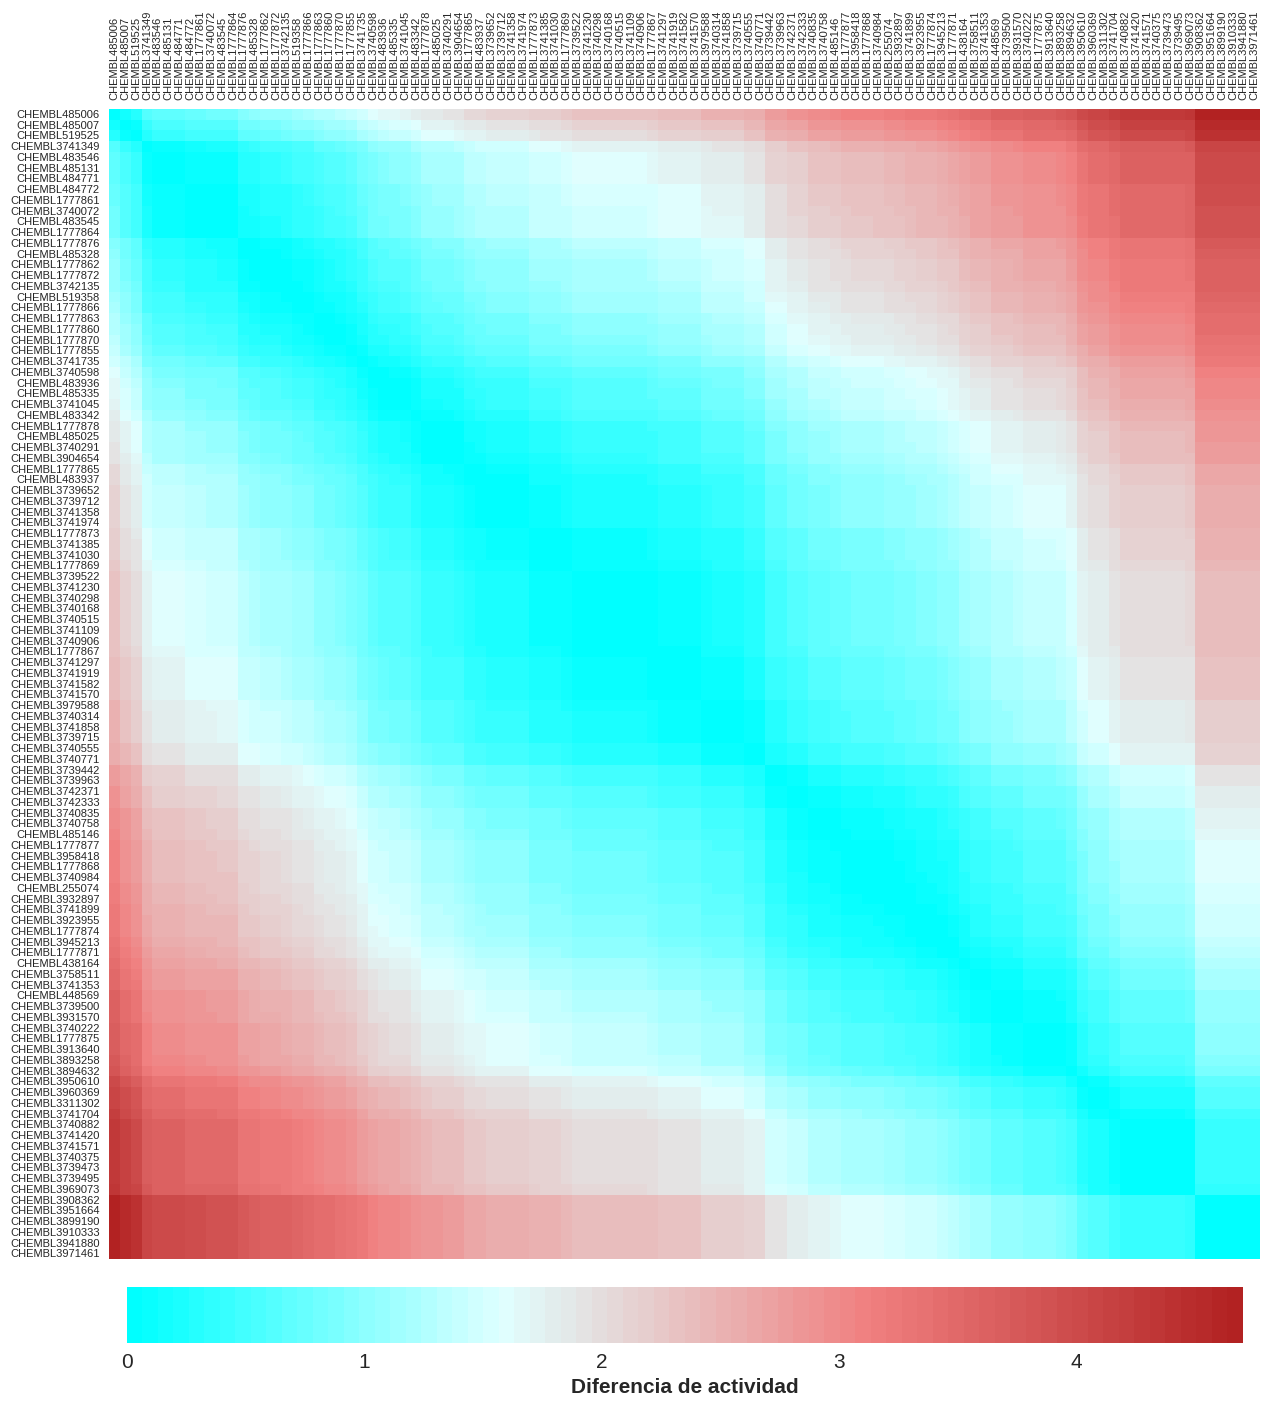

In [15]:
fig, ax = plt.subplots(figsize=(18,18))
sns.heatmap(hmap,square = True, xticklabels=hmap.columns, yticklabels=hmap.index, cmap=palette,
            cbar_kws={'shrink':0.8,
                      'orientation':'horizontal','spacing':'uniform',
                      'pad':0.02})
ax.figure.axes[1].tick_params(axis="x", labelsize=15) #Tamaño de ticks en cbar
ax.figure.axes[1].set_xlabel('Diferencia de actividad', size=15, weight='bold') #Etiqueta de cbar
ax.tick_params(labelsize=1)
plt.xticks (np.arange(len(hmap.index))+0.5, hmap.index,rotation=90)
plt.yticks (np.arange(len(hmap.columns))+0.5, hmap.columns, rotation=0)
ax.xaxis.tick_top()
plt.tick_params ('both',width=1,labelsize=8)
plt.show()

<a name='3'></a>

#**Sección 3. Cálculo de similitud molecular a partir de la generación de fingerprints y el empleo del Coeficiente de Tanimoto.**

En esta sección se generara un loop iterativo para la obtención de fingerprints (radiales del tipo ECFP6 con ayuda de RDKit) y, posteriormente se empleará el coeficiente de Tanimoto para el establecimeinto del cálculo de similitud.

  Nota: pueden utilizarse otro tipo de representaciones moleculares, no necesariamente fingerprints ECFP6.


In [16]:
 tic =time.time()
comparacion_estructura = [] # Lista en donde se almacenan los casos de comparación.
for i in range(len(db_treatment)):
    elemento_fijo_id = db_treatment.loc[[i], ["Molecule ChEMBL ID"]]
    elemento_fijo_df = db_treatment.loc[[i], ["Smiles"]]    # iteración sobre todos los compuestos de la base de datos, en este caso, su representación tipo SMILES.
    elemento_fijo_str = elemento_fijo_df.to_string(index = False, header = False)     # al recorrer/iterar sobre cada uno de los elementos, su reconocimiento no es directamente "string" (que es lo que necesitamos para el método 'GetMorgan'), sino que se obtiene como un "dataframe" por lo que el método "tostring" permite realizar esta conversión.
    elemento_fijo_mol = Chem.MolFromSmiles(elemento_fijo_str)    # al contar con el compuesto en su representación SMILES y en formato string, entoces podemos utilizar RDKit para generar un objeto tipo "mol".
    fps_elemento_fijo = AllChem.GetMorganFingerprintAsBitVect(elemento_fijo_mol, 2, nBits = 1024)  # Morgan toma ese objeto tipo mol y genera un fingerprint. Al mismo tiempo, al utilizar Morgan el usuario tiene que definir un radio a partir el cual se emplea para la generación del fingerprint: en este caso utilizamos "2". El término "n = 1024" es el tamaño del vector de bits generado.

    for j in range(i+1, len(db_treatment)):               #Sub ciclo donde se genera el fingerprint para "elemento_variable".

        elemento_variable_id = db_treatment.loc[[j], ["Molecule ChEMBL ID"]]
        elemento_variable_df = db_treatment.loc[[j], ["Smiles"]]
        elemento_variable_str = elemento_variable_df.to_string(index = False, header = False)
        elemento_variable_mol = Chem.MolFromSmiles(elemento_variable_str)
        fps_elemento_variable = AllChem.GetMorganFingerprintAsBitVect(elemento_variable_mol, 3, nBits = 2048) #ECFP6

        diferencia_estructura = DataStructs.TanimotoSimilarity(fps_elemento_fijo, fps_elemento_variable)

        comparacion_estructura.append({"Compuesto A": elemento_fijo_id.to_string(index = False, header = False),
                                       "Smiles A": elemento_fijo_str,

                                      "Compuesto B": elemento_variable_id.to_string(index = False, header = False),
                                       "Smiles B": elemento_variable_str,

                                      "Similitud estructural (Tanimoto)": diferencia_estructura})

estructura_db = pd.DataFrame(comparacion_estructura)  # dataframe con todas las comparaciones posibles de similitud estructural.
toc =time.time()
print("Time: "+ str((toc-tic))+" s")
estructura_db

# Nota : esta sección de código puede reducirse en la parte de la conversión "dataframe" a "string". Si desde un principio en la base de datos pretratada especificamos "dtype=string" para la columna SMILES ya no es necesario realizar la conversión.

Time: 25.622435808181763 s


,Compuesto A,Smiles A,Compuesto B,Smiles B,Similitud estructural (Tanimoto)
0,CHEMBL485006,CCCN1C(=O)c2ccccc2[C@@H](C(=O)O)[C@@H]1c1ccc(O...,CHEMBL485007,CCCN1C(=O)c2ccccc2[C@@H](C(=O)O)[C@@H]1c1ccc(O...,0.613333
1,CHEMBL485006,CCCN1C(=O)c2ccccc2[C@@H](C(=O)O)[C@@H]1c1ccc(O...,CHEMBL519525,O=C(O)[C@@H]1c2ccccc2C(=O)N(CC2CC2)[C@H]1c1ccc...,0.462500
2,CHEMBL485006,CCCN1C(=O)c2ccccc2[C@@H](C(=O)O)[C@@H]1c1ccc(O...,CHEMBL3741349,Fc1ccc(OCc2cc(OCC(F)(F)F)nc(-c3ccccn3)n2)c(F)c1F,0.091743
3,CHEMBL485006,CCCN1C(=O)c2ccccc2[C@@H](C(=O)O)[C@@H]1c1ccc(O...,CHEMBL483546,CCC(CC)CN1C(=O)c2ccccc2[C@@H](C(=O)O)[C@@H]1c1...,0.402439
4,CHEMBL485006,CCCN1C(=O)c2ccccc2[C@@H](C(=O)O)[C@@H]1c1ccc(O...,CHEMBL485131,CCC(CC)CN1C(=O)c2ccccc2[C@@H](C(=O)O)[C@@H]1c1...,0.337079
...,...,...,...,...,...
5666,CHEMBL3899190,O=S1(=O)c2ccccc2CN1c1cccc(Oc2ccccn2)c1,CHEMBL3941880,O=S1(=O)c2ccccc2CN1c1cc(F)cc(Oc2ccccn2)c1,0.553846
5667,CHEMBL3899190,O=S1(=O)c2ccccc2CN1c1cccc(Oc2ccccn2)c1,CHEMBL3971461,O=S1(=O)c2ccccc2CN1c1cc(F)cc(Oc2ccncc2)c1,0.400000
5668,CHEMBL3910333,O=S1(=O)c2ccccc2CN1c1cc(Cl)cc(Oc2ccccn2)c1,CHEMBL3941880,O=S1(=O)c2ccccc2CN1c1cc(F)cc(Oc2ccccn2)c1,0.584615
5669,CHEMBL3910333,O=S1(=O)c2ccccc2CN1c1cc(Cl)cc(Oc2ccccn2)c1,CHEMBL3971461,O=S1(=O)c2ccccc2CN1c1cc(F)cc(Oc2ccncc2)c1,0.428571


<a name='3.1'></a>

##**Matriz de similitud**

In [17]:
def tanimoto_calc(smi1, smi2):
    mol1 = Chem.MolFromSmiles(smi1)
    mol2 = Chem.MolFromSmiles(smi2)
    fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, 3, nBits=2048)
    fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, 3, nBits=2048)
    s = round(DataStructs.TanimotoSimilarity(fp1,fp2),3)
    return s

In [18]:
db_treatment.sort_values(by=["Molecule ChEMBL ID"], ascending=False, inplace=True) #Se ordena con respecto al ID para obtener una mejor visualización
db_treatment.reset_index(drop=True, inplace=True)

tic =time.time()
hmap_similarity=pd.DataFrame()
for i in db_treatment.index:
    for j in db_treatment.index:
        a=db_treatment.loc[i].at['Smiles']
        b=db_treatment.loc[j].at['Smiles']
        alignment= tanimoto_calc(a,b)
        hmap_similarity.loc[db_treatment.loc[i,'Molecule ChEMBL ID'],db_treatment.loc[j,'Molecule ChEMBL ID']]=alignment
toc =time.time()
print("Time: "+ str((toc-tic))+" s")

hmap_similarity

<ipython-input-18-c25ff181446c>:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  hmap_similarity.loc[db_treatment.loc[i,'Molecule ChEMBL ID'],db_treatment.loc[j,'Molecule ChEMBL ID']]=alignment
<ipython-input-18-c25ff181446c>:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  hmap_similarity.loc[db_treatment.loc[i,'Molecule ChEMBL ID'],db_treatment.loc[j,'Molecule ChEMBL ID']]=alignment
<ipython-input-18-c25ff181446c>:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

Time: 15.195949792861938 s


,CHEMBL519525,CHEMBL519358,CHEMBL485335,CHEMBL485328,CHEMBL485146,CHEMBL485131,CHEMBL485025,CHEMBL485007,CHEMBL485006,CHEMBL484772,...,CHEMBL1777868,CHEMBL1777867,CHEMBL1777866,CHEMBL1777865,CHEMBL1777864,CHEMBL1777863,CHEMBL1777862,CHEMBL1777861,CHEMBL1777860,CHEMBL1777855
CHEMBL519525,1.000,0.455,0.467,0.314,0.506,0.320,0.597,0.516,0.528,0.716,...,0.128,0.146,0.113,0.140,0.153,0.147,0.136,0.121,0.127,0.116
CHEMBL519358,0.455,1.000,0.581,0.316,0.631,0.321,0.421,0.613,0.609,0.511,...,0.154,0.171,0.207,0.174,0.148,0.142,0.132,0.183,0.193,0.167
CHEMBL485335,0.467,0.581,1.000,0.330,0.707,0.337,0.432,0.602,0.616,0.529,...,0.125,0.131,0.110,0.118,0.129,0.133,0.123,0.108,0.114,0.113
CHEMBL485328,0.314,0.316,0.330,1.000,0.365,0.420,0.303,0.346,0.340,0.371,...,0.103,0.107,0.098,0.097,0.107,0.101,0.101,0.088,0.092,0.093
CHEMBL485146,0.506,0.631,0.707,0.365,1.000,0.372,0.468,0.679,0.697,0.579,...,0.137,0.144,0.131,0.139,0.152,0.146,0.135,0.118,0.125,0.123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHEMBL1777863,0.147,0.142,0.133,0.101,0.146,0.093,0.149,0.149,0.162,0.165,...,0.487,0.500,0.424,0.464,0.532,1.000,0.686,0.482,0.519,0.293
CHEMBL1777862,0.136,0.132,0.123,0.101,0.135,0.093,0.149,0.139,0.152,0.154,...,0.487,0.461,0.476,0.464,0.532,0.686,1.000,0.500,0.519,0.320
CHEMBL1777861,0.121,0.183,0.108,0.088,0.118,0.081,0.131,0.124,0.136,0.136,...,0.407,0.432,0.500,0.506,0.448,0.482,0.500,1.000,0.671,0.642
CHEMBL1777860,0.127,0.193,0.114,0.092,0.125,0.085,0.139,0.150,0.153,0.144,...,0.438,0.467,0.538,0.544,0.481,0.519,0.519,0.671,1.000,0.427


<a name='3.2'></a>

##**Visualización (Heat map)**

In [19]:
palette= sns.blend_palette(['green','greenyellow','yellow', 'orange'],72)
palette

[(0.0, 0.5019607843137255, 0.0),
 (0.023944636678200692, 0.5195386389850057, 0.006505190311418685),
 (0.05587081891580162, 0.5429757785467128, 0.015178777393310266),
 (0.07981545559400231, 0.5605536332179931, 0.02168396770472895),
 (0.11174163783160324, 0.5839907727797001, 0.03035755478662053),
 (0.14366782006920414, 0.6074279123414071, 0.039031141868512115),
 (0.16761245674740485, 0.6250057670126874, 0.0455363321799308),
 (0.1995386389850058, 0.6484429065743944, 0.05420991926182238),
 (0.22348327566320647, 0.6660207612456748, 0.06071510957324106),
 (0.2554094579008074, 0.6894579008073818, 0.06938869665513264),
 (0.2873356401384083, 0.7128950403690888, 0.07806228373702423),
 (0.311280276816609, 0.730472895040369, 0.0845674740484429),
 (0.34320645905420993, 0.7539100346020762, 0.0932410611303345),
 (0.3671510957324106, 0.7714878892733563, 0.09974625144175317),
 (0.3990772779700116, 0.7949250288350634, 0.10841983852364476),
 (0.43100346020761243, 0.8183621683967705, 0.11709342560553633),
 (0.4549480968858131, 0.8359400230680507, 0.12359861591695502),
 (0.486874279123414, 0.8593771626297577, 0.1322722029988466),
 (0.5108189158016148, 0.8769550173010381, 0.13877739331026528),
 (0.5427450980392158, 0.9003921568627451, 0.14745098039215687),
 (0.5746712802768166, 0.9238292964244521, 0.15612456747404846),
 (0.5986159169550173, 0.9414071510957325, 0.16262975778546712),
 (0.6305420991926183, 0.9648442906574395, 0.17130334486735874),
 (0.6544867358708188, 0.9824221453287196, 0.17780853517877737),
 (0.6822145328719723, 1.0, 0.1821453287197232),
 (0.6973471741637831, 1.0, 0.17347174163783163),
 (0.7086966551326414, 1.0, 0.16696655132641292),
 (0.7238292964244522, 1.0, 0.15829296424452136),
 (0.7351787773933103, 1.0, 0.15178777393310267),
 (0.7503114186851212, 1.0, 0.14311418685121108),
 (0.765444059976932, 1.0, 0.1344405997693195),
 (0.7767935409457901, 1.0, 0.1279354094579008),
 (0.7919261822376009, 1.0, 0.11926182237600923),
 (0.803275663206459, 1.0, 0.11275663206459055),
 (0.8184083044982698, 1.0, 0.10408304498269899),
 (0.8335409457900808, 1.0, 0.09540945790080739),
 (0.8448904267589389, 1.0, 0.0889042675893887),
 (0.8600230680507497, 1.0, 0.08023068050749713),
 (0.8751557093425606, 1.0, 0.07155709342560553),
 (0.8865051903114187, 1.0, 0.06505190311418685),
 (0.9016378316032295, 1.0, 0.05637831603229529),
 (0.9129873125720877, 1.0, 0.0498731257208766),
 (0.9281199538638985, 1.0, 0.04119953863898501),
 (0.9432525951557094, 1.0, 0.032525951557093424),
 (0.9546020761245675, 1.0, 0.02602076124567476),
 (0.9697347174163784, 1.0, 0.017347174163783174),
 (0.9810841983852365, 1.0, 0.010841983852364484),
 (0.9962168396770473, 1.0, 0.002168396770472897),
 (1.0, 0.9875432525951557, 0.0),
 (1.0, 0.9750865051903114, 0.0),
 (1.0, 0.9584775086505192, 0.0),
 (1.0, 0.9460207612456747, 0.0),
 (1.0, 0.9294117647058824, 0.0),
 (1.0, 0.91280276816609, 0.0),
 (1.0, 0.9003460207612457, 0.0),
 (1.0, 0.8837370242214533, 0.0),
 (1.0, 0.871280276816609, 0.0),
 (1.0, 0.8546712802768166, 0.0),
 (1.0, 0.8380622837370242, 0.0),
 (1.0, 0.82560553633218, 0.0),
 (1.0, 0.8089965397923876, 0.0),
 (1.0, 0.7965397923875432, 0.0),
 (1.0, 0.7799307958477508, 0.0),
 (1.0, 0.7633217993079585, 0.0),
 (1.0, 0.7508650519031141, 0.0),
 (1.0, 0.7342560553633218, 0.0),
 (1.0, 0.7217993079584775, 0.0),
 (1.0, 0.7051903114186852, 0.0),
 (1.0, 0.6885813148788928, 0.0),
 (1.0, 0.6761245674740485, 0.0),
 (1.0, 0.6595155709342561, 0.0),
 (1.0, 0.6470588235294118, 0.0)]

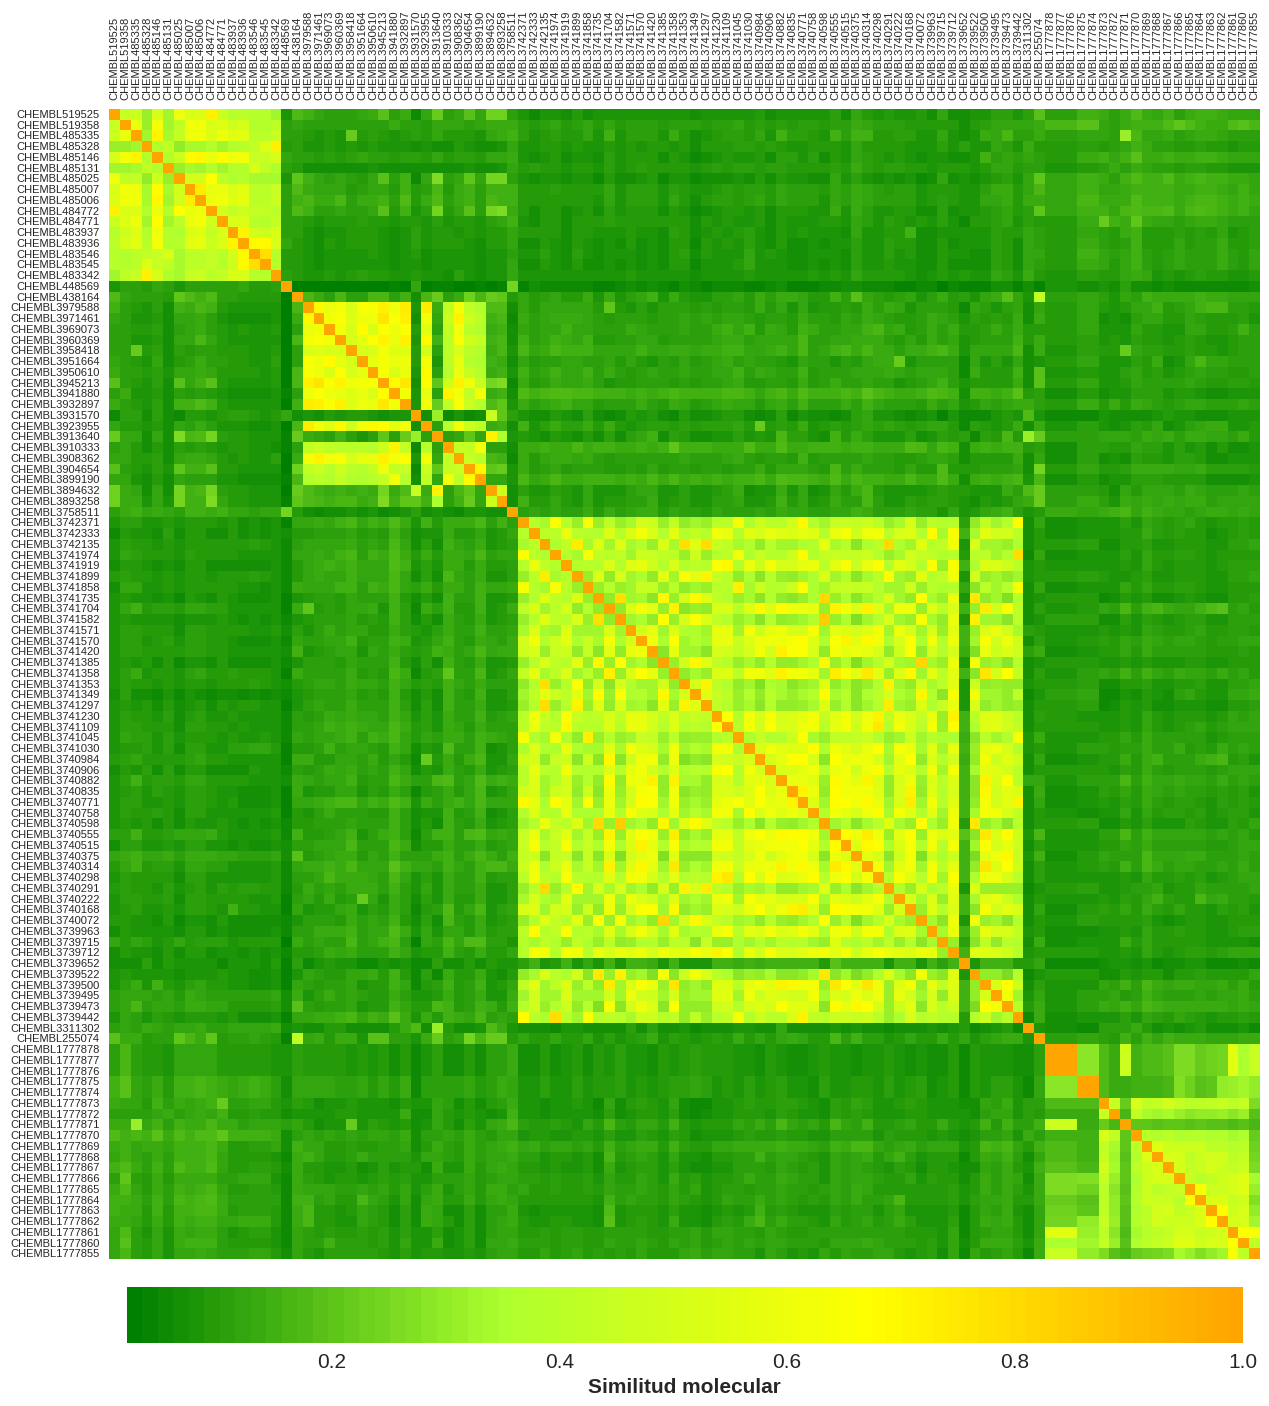

In [20]:
fig, ax = plt.subplots(figsize=(18,18))
sns.heatmap(hmap_similarity,square = True, xticklabels=hmap_similarity.columns, yticklabels=hmap_similarity.index, cmap=palette,
            cbar_kws={'shrink':0.8,
                      'orientation':'horizontal','spacing':'uniform',
                      'pad':0.02})
ax.figure.axes[1].tick_params(axis="x", labelsize=15) #Tamaño de ticks en cbar
ax.figure.axes[1].set_xlabel('Similitud molecular', size=15, weight='bold') #Etiqueta de cbar
ax.tick_params(labelsize=1)
plt.xticks (np.arange(len(hmap_similarity.index))+0.5, hmap_similarity.index,rotation=90)
plt.yticks (np.arange(len(hmap_similarity.columns))+0.5, hmap_similarity.columns, rotation=0)
ax.xaxis.tick_top()
plt.tick_params ('both',width=1,labelsize=8)
plt.show()

Para cuantificar el panorama de actividad se emplea el indice SALI (Indice del panorama estructura-actividad:


```
# SALIi,j = |Ai − Aj|/1 − sim(i,j)

```
El valor SALI será empleado para mapear lo anterior en un mapa SAS usando una escala de color continua desde x(valores bajos SALI) hasta y (valores altos SALI asociados con ACs).
Para este segmento consideramos que dos compuestos están conectados si tienen un score SALI superior al limite de corte establecido (mayor al 70 u 80% de todos los scores)
https://pubs.rsc.org/en/content/articlehtml/2023/dd/d3dd00098b


In [21]:
merge=actividad_db.merge(right=estructura_db, on=['Compuesto A', 'Compuesto B']) #Juntamos los DF
merge= merge[['Compuesto A',	'pIC50 A', 'Smiles A','Compuesto B',	'pIC50 B','Smiles B','Diferencia de actividad',	'Similitud estructural (Tanimoto)']]

merge['pIC50 A'] = merge['pIC50 A'].round(4)
merge['pIC50 B'] = merge['pIC50 B'].round(4)
merge['Diferencia de actividad'] = merge['Diferencia de actividad'].round(4)
merge['Similitud estructural (Tanimoto)'] = merge['Similitud estructural (Tanimoto)'].round(4)
merge['Valor de SALI'] = (merge['Diferencia de actividad'] / (1 - merge['Similitud estructural (Tanimoto)'])).round(4)   # para obtener el valor de SALi podemos usar la expresión aritmética directamente sin necesidad de iterar sobre todos los renglones de las columnas.


merge

,Compuesto A,pIC50 A,Smiles A,Compuesto B,pIC50 B,Smiles B,Diferencia de actividad,Similitud estructural (Tanimoto),Valor de SALI
0,CHEMBL485006,8.699,CCCN1C(=O)c2ccccc2[C@@H](C(=O)O)[C@@H]1c1ccc(O...,CHEMBL485007,8.5229,CCCN1C(=O)c2ccccc2[C@@H](C(=O)O)[C@@H]1c1ccc(O...,0.1761,0.6133,0.4554
1,CHEMBL485006,8.699,CCCN1C(=O)c2ccccc2[C@@H](C(=O)O)[C@@H]1c1ccc(O...,CHEMBL519525,8.3979,O=C(O)[C@@H]1c2ccccc2C(=O)N(CC2CC2)[C@H]1c1ccc...,0.3010,0.4625,0.5600
2,CHEMBL485006,8.699,CCCN1C(=O)c2ccccc2[C@@H](C(=O)O)[C@@H]1c1ccc(O...,CHEMBL3741349,8.1000,Fc1ccc(OCc2cc(OCC(F)(F)F)nc(-c3ccccn3)n2)c(F)c1F,0.5990,0.0917,0.6595
3,CHEMBL485006,8.699,CCCN1C(=O)c2ccccc2[C@@H](C(=O)O)[C@@H]1c1ccc(O...,CHEMBL483546,8.0000,CCC(CC)CN1C(=O)c2ccccc2[C@@H](C(=O)O)[C@@H]1c1...,0.6990,0.4024,1.1697
4,CHEMBL485006,8.699,CCCN1C(=O)c2ccccc2[C@@H](C(=O)O)[C@@H]1c1ccc(O...,CHEMBL485131,8.0000,CCC(CC)CN1C(=O)c2ccccc2[C@@H](C(=O)O)[C@@H]1c1...,0.6990,0.3371,1.0545
...,...,...,...,...,...,...,...,...,...
5666,CHEMBL3899190,4.000,O=S1(=O)c2ccccc2CN1c1cccc(Oc2ccccn2)c1,CHEMBL3941880,4.0000,O=S1(=O)c2ccccc2CN1c1cc(F)cc(Oc2ccccn2)c1,0.0000,0.5538,0.0000
5667,CHEMBL3899190,4.000,O=S1(=O)c2ccccc2CN1c1cccc(Oc2ccccn2)c1,CHEMBL3971461,4.0000,O=S1(=O)c2ccccc2CN1c1cc(F)cc(Oc2ccncc2)c1,0.0000,0.4000,0.0000
5668,CHEMBL3910333,4.000,O=S1(=O)c2ccccc2CN1c1cc(Cl)cc(Oc2ccccn2)c1,CHEMBL3941880,4.0000,O=S1(=O)c2ccccc2CN1c1cc(F)cc(Oc2ccccn2)c1,0.0000,0.5846,0.0000
5669,CHEMBL3910333,4.000,O=S1(=O)c2ccccc2CN1c1cc(Cl)cc(Oc2ccccn2)c1,CHEMBL3971461,4.0000,O=S1(=O)c2ccccc2CN1c1cc(F)cc(Oc2ccncc2)c1,0.0000,0.4286,0.0000


<a name='4'></a>

#**Sección 4. Visualización y análisis de datos**
La elección de la métrica para definir si algo es un "activity cliff" (ACs) depende en gran medida del contexto específico de tu problema y de tus objetivos. Sin embargo, algunas métricas comunes que podrías considerar son:


1. **Umbral Absoluto:** Puedes establecer un umbral absoluto para la diferencia de actividad y considerar cualquier diferencia que supere ese umbral como un "activity cliff". Por ejemplo, podrías decidir que cualquier diferencia mayor que 1.5 es un "cliff".

2. **Umbral Relativo:**En lugar de un umbral absoluto, podrías considerar un umbral relativo en función de la variabilidad de tus datos. Por ejemplo, podrías definir "activity cliffs" como aquellas diferencias que superan cierto múltiplo de la desviación estándar.

3. **Percentil:** Podrías identificar "activity cliffs" basándote en ciertos percentiles de la distribución de las diferencias. Por ejemplo, podrías considerar aquellos que están por encima del 90% superior como "cliffs".

4. **Criterios Biológicos o Químicos:** Dependiendo del dominio de tu problema, podrías incorporar conocimientos biológicos o químicos para definir "activity cliffs". Por ejemplo, podrías considerar como "cliffs" aquellas diferencias que conduzcan a cambios significativos en la estructura química.

In [22]:
print(f"Estadística de la columna 'Diferencia de actividad': {merge['Diferencia de actividad'].describe()}")
print(f"Estadística de la columna 'Similitud estructural (Tanimoto)': {merge['Similitud estructural (Tanimoto)'].describe()}")
print(f"Estadística de la columna 'Valor de SALI': {merge['Valor de SALI'].describe()}")

Estadística de la columna 'Diferencia de actividad': count    5671.000000
mean        1.388091
std         0.990511
min         0.000000
25%         0.600000
50%         1.210000
75%         2.023100
max         4.699000
Name: Diferencia de actividad, dtype: float64
Estadística de la columna 'Similitud estructural (Tanimoto)': count    5671.000000
mean        0.201270
std         0.140737
min         0.022700
25%         0.111100
50%         0.136400
75%         0.237950
max         0.806500
Name: Similitud estructural (Tanimoto), dtype: float64
Estadística de la columna 'Valor de SALI': count    5671.000000
mean        1.744984
std         1.226973
min         0.000000
25%         0.744100
50%         1.506000
75%         2.616150
max         9.468900
Name: Valor de SALI, dtype: float64


Considerando la información anterior, podemos establecer dos tipos de umbrales, unos absolutos (25%, 50%, 75%) y unos realtivos considerando:
1. Diferencia de Actividad (pIC50):
    - Dado que la media es 1.388 y la desviación estándar es 0.990511, se podría considerar umbrales que estén en el rango de 1 a 2 desviaciones estándar de la media.
    Por ejemplo, podriamos definir como "alta" diferencia de actividad aquellas mayores que, por ejemplo, 2.5 (media + 2 * desviación estándar).
2. Similitud Estructural (Tanimoto):
  - Podrías definir como "alta" similitud aquella mayor que, por ejemplo, 0.482 (media + 2 * desviación estándar).

<a name='4.1'></a>
## **Identificación de "activity cliffs" (ACs).**

<a name='4.1.1'></a>

### **Establecimiento de umbrales relativos y absolutos**

In [23]:
#Umbrales absolutos--->  considerando el 25%, 50% y 75% en ambos casos
thresholds_ActivityDiff_25= 0.600000
thresholds_Similarity_25 = 0.111100
thresholds_ActivityDiff_50= 1.210000
thresholds_Similarity_50 = 0.136400
thresholds_ActivityDiff_75= 2.023100
thresholds_Similarity_75 = 0.237950

print(f"(Abs: 25%) Será un activity cliff todo par de moléculas que tenga una diferencia de actividad mayor que {thresholds_ActivityDiff_25} y una similitud mayor que {thresholds_Similarity_25}")
print(f"(Abs: 50%) Será un activity cliff todo par de moléculas que tenga una diferencia de actividad mayor que {thresholds_ActivityDiff_50} y una similitud mayor que {thresholds_Similarity_50}")
print(f"(Abs: 75%) Será un activity cliff todo par de moléculas que tenga una diferencia de actividad mayor que {thresholds_ActivityDiff_75} y una similitud mayor que {thresholds_Similarity_75}")

above_25 = merge.loc[((merge['Similitud estructural (Tanimoto)'] > thresholds_Similarity_25) & (merge['Diferencia de actividad'] > thresholds_ActivityDiff_25))]
above_50 = merge.loc[((merge['Similitud estructural (Tanimoto)'] > thresholds_Similarity_50) & (merge['Diferencia de actividad'] > thresholds_ActivityDiff_50))]
above_75 = merge.loc[((merge['Similitud estructural (Tanimoto)'] > thresholds_Similarity_75) & (merge['Diferencia de actividad'] > thresholds_ActivityDiff_75))]

#Umbrales Relativos considerando promedio + 2 veces la desviación estandar
thresholds_ActivityDiff_rel= merge['Diferencia de actividad'].mean() + 2 * merge['Diferencia de actividad'].std()
thresholds_Similarity = merge['Similitud estructural (Tanimoto)'].mean() + 2 * merge['Similitud estructural (Tanimoto)'].std()
print(f"(Rel) Será un activity cliff todo par de moléculas que tenga una diferencia de actividad mayor que {thresholds_ActivityDiff_rel.round(2)} y una similitud mayor que {thresholds_Similarity.round(2)}")
above_rel_2std = merge.loc[(merge['Similitud estructural (Tanimoto)'] > thresholds_Similarity) & (merge['Diferencia de actividad'] > thresholds_ActivityDiff_rel)]

#Umbrales Relativos considerando promedio + 2 veces la desviación estandar y una diferencia de actividad menor a 0.1
y_cut_value_cliffs = 0.1
above_rel_2std_01DifAct = merge.loc[(merge['Similitud estructural (Tanimoto)'] > thresholds_Similarity) & (merge['Diferencia de actividad'] <= y_cut_value_cliffs)]

print(f"(Rel_2) Será un activity cliff todo par de moléculas que tenga una diferencia de actividad mayor que {thresholds_ActivityDiff_rel.round(2)} y una similitud menor o igual que {y_cut_value_cliffs}")

print(f"Cantidad de activity cliffs considerando umbrales absolutos del 25%: {len(above_25)}, 50%: {len(above_50)} y 75%: {len(above_75)}")
print(f"Cantidad de activity cliffs considerando umbrales relativos personalizados por enzima de 2 veces la desviación estándar: {len(above_rel_2std)}")
print(f"Cantidad de activity cliffs considerando umbrales relativos personalizados a una diferencia de actividad menor a 0.1: {len(above_rel_2std_01DifAct)}")

(Abs: 25%) Será un activity cliff todo par de moléculas que tenga una diferencia de actividad mayor que 0.6 y una similitud mayor que 0.1111
(Abs: 50%) Será un activity cliff todo par de moléculas que tenga una diferencia de actividad mayor que 1.21 y una similitud mayor que 0.1364
(Abs: 75%) Será un activity cliff todo par de moléculas que tenga una diferencia de actividad mayor que 2.0231 y una similitud mayor que 0.23795
(Rel) Será un activity cliff todo par de moléculas que tenga una diferencia de actividad mayor que 3.37 y una similitud mayor que 0.48
(Rel_2) Será un activity cliff todo par de moléculas que tenga una diferencia de actividad mayor que 3.37 y una similitud menor o igual que 0.1
Cantidad de activity cliffs considerando umbrales absolutos del 25%: 3038, 50%: 1308 y 75%: 150
Cantidad de activity cliffs considerando umbrales relativos personalizados por enzima de 2 veces la desviación estándar: 0
Cantidad de activity cliffs considerando umbrales relativos personalizados

In [24]:
# Instancia para la obtención del link de ChEMBL de cada compuesto.
def generate_chembl_link(chembl_id):
    return f'[Link](https://www.ebi.ac.uk/chembl/compound_report_card/{chembl_id})'
list_df=[above_25, above_50, above_75, above_rel_2std, above_rel_2std_01DifAct]
columns_new_order = ['Compuesto A', 'Smiles A', 'pIC50 A','Ficha de acceso A','Compuesto B', 'Smiles B', 'pIC50 B',
                                'Ficha de acceso B','Diferencia de actividad','Similitud estructural (Tanimoto)',  'Valor de SALI']
for i in list_df:
    i['Ficha de acceso A'] = i['Compuesto A'].apply(generate_chembl_link)
    i['Ficha de acceso B'] = i['Compuesto B'].apply(generate_chembl_link)

above_25 = above_25.reindex(columns=columns_new_order)
above_50 = above_50.reindex(columns=columns_new_order)
above_75 = above_75.reindex(columns=columns_new_order)
above_rel_2std = above_rel_2std.reindex(columns=columns_new_order)
above_rel_2std_01DifAct = above_rel_2std_01DifAct.reindex(columns=columns_new_order)
# above_25.to_excel('above_25.xlsx')  # creaciónde hoja de cálculo
above_rel_2std_01DifAct

<ipython-input-24-a5ab2834cb69>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i['Ficha de acceso A'] = i['Compuesto A'].apply(generate_chembl_link)
<ipython-input-24-a5ab2834cb69>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i['Ficha de acceso B'] = i['Compuesto B'].apply(generate_chembl_link)
<ipython-input-24-a5ab2834cb69>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

,Compuesto A,Smiles A,pIC50 A,Ficha de acceso A,Compuesto B,Smiles B,pIC50 B,Ficha de acceso B,Diferencia de actividad,Similitud estructural (Tanimoto),Valor de SALI
418,CHEMBL483546,CCC(CC)CN1C(=O)c2ccccc2[C@@H](C(=O)O)[C@@H]1c1...,8.0000,[Link](https://www.ebi.ac.uk/chembl/compound_r...,CHEMBL485131,CCC(CC)CN1C(=O)c2ccccc2[C@@H](C(=O)O)[C@@H]1c1...,8.0000,[Link](https://www.ebi.ac.uk/chembl/compound_r...,0.0000,0.5000,0.0000
1931,CHEMBL1777860,CC#CC(CC(=O)O)c1ccc(Oc2ccc(C(F)(F)F)cc2C)cc1,7.3979,[Link](https://www.ebi.ac.uk/chembl/compound_r...,CHEMBL1777855,CC#CC(CC(=O)O)c1ccc(Oc2ccc(C(F)(F)F)cc2OC(F)F)...,7.3098,[Link](https://www.ebi.ac.uk/chembl/compound_r...,0.0881,0.4935,0.1739
2185,CHEMBL3741735,Fc1ccc(OCc2cc(OCC3(F)COC3)nc(-c3ccccn3)n2)c(F)c1F,7.2000,[Link](https://www.ebi.ac.uk/chembl/compound_r...,CHEMBL3740598,CC1(COc2cc(COc3ccc(F)c(F)c3F)nc(-c3ccccn3)n2)COC1,7.1000,[Link](https://www.ebi.ac.uk/chembl/compound_r...,0.1000,0.6282,0.2690
3186,CHEMBL3739712,Cc1cc(COc2ccc(F)c(F)c2F)nc(-c2ccccn2)n1,6.6000,[Link](https://www.ebi.ac.uk/chembl/compound_r...,CHEMBL3741358,Cc1cc(COc2ccc(Cl)cc2)nc(-c2ccccn2)n1,6.6000,[Link](https://www.ebi.ac.uk/chembl/compound_r...,0.0000,0.5312,0.0000
3190,CHEMBL3739712,Cc1cc(COc2ccc(F)c(F)c2F)nc(-c2ccccn2)n1,6.6000,[Link](https://www.ebi.ac.uk/chembl/compound_r...,CHEMBL3741030,Cc1cc(COc2ccccc2Cl)nc(-c2ccccn2)n1,6.5000,[Link](https://www.ebi.ac.uk/chembl/compound_r...,0.1000,0.5231,0.2097
...,...,...,...,...,...,...,...,...,...,...,...
5664,CHEMBL3951664,N#Cc1ccccc1Oc1cc(F)cc(N2Cc3ccccc3S2(=O)=O)c1,4.0000,[Link](https://www.ebi.ac.uk/chembl/compound_r...,CHEMBL3971461,O=S1(=O)c2ccccc2CN1c1cc(F)cc(Oc2ccncc2)c1,4.0000,[Link](https://www.ebi.ac.uk/chembl/compound_r...,0.0000,0.5147,0.0000
5665,CHEMBL3899190,O=S1(=O)c2ccccc2CN1c1cccc(Oc2ccccn2)c1,4.0000,[Link](https://www.ebi.ac.uk/chembl/compound_r...,CHEMBL3910333,O=S1(=O)c2ccccc2CN1c1cc(Cl)cc(Oc2ccccn2)c1,4.0000,[Link](https://www.ebi.ac.uk/chembl/compound_r...,0.0000,0.5625,0.0000
5666,CHEMBL3899190,O=S1(=O)c2ccccc2CN1c1cccc(Oc2ccccn2)c1,4.0000,[Link](https://www.ebi.ac.uk/chembl/compound_r...,CHEMBL3941880,O=S1(=O)c2ccccc2CN1c1cc(F)cc(Oc2ccccn2)c1,4.0000,[Link](https://www.ebi.ac.uk/chembl/compound_r...,0.0000,0.5538,0.0000
5668,CHEMBL3910333,O=S1(=O)c2ccccc2CN1c1cc(Cl)cc(Oc2ccccn2)c1,4.0000,[Link](https://www.ebi.ac.uk/chembl/compound_r...,CHEMBL3941880,O=S1(=O)c2ccccc2CN1c1cc(F)cc(Oc2ccccn2)c1,4.0000,[Link](https://www.ebi.ac.uk/chembl/compound_r...,0.0000,0.5846,0.0000


**importante** si se desea generar links de diferentes bases de datos públicas: de momento solo se ha trabajado con ChEMBL.

'markdorwn string type: sintaxis para visualizar links en un dataframe. [Link (puede ser cualquier otra palabra)'ruta de ChEMBL para consultar fichas de compuestos y {entre llaves la variable que deseas agregar a la cadena de texto}.]

<a name='4.1.2'></a>

### **Visualización de ACs**

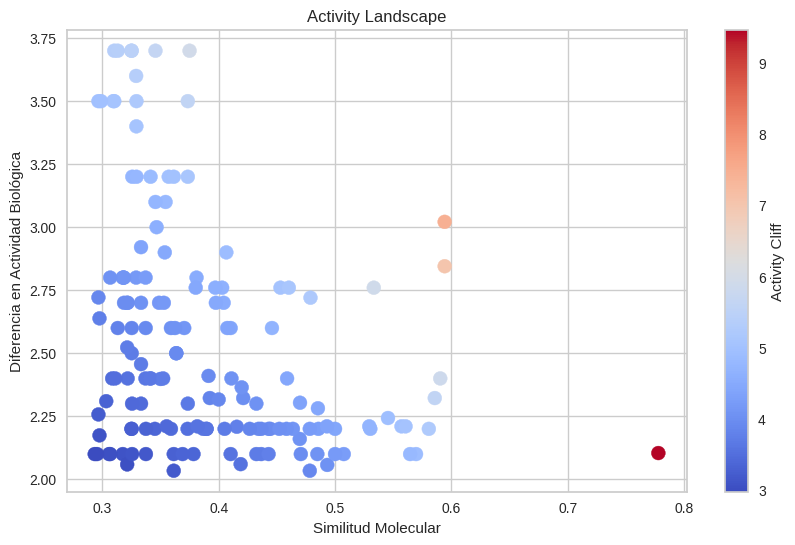

In [25]:
# Visualización
plt.figure(figsize=(10, 6))
plt.scatter(above_75['Similitud estructural (Tanimoto)'], above_75['Diferencia de actividad'], c=above_75['Valor de SALI'], cmap='coolwarm', s=100)
plt.xlabel('Similitud Molecular')
plt.ylabel('Diferencia en Actividad Biológica')
plt.title('Activity Landscape')
plt.colorbar(label='Activity Cliff')
plt.show()

In [26]:
def visualización_activity_cliffs(df, title=''):
  # Visualización
  plt.figure(figsize=(10, 6))
  plt.scatter(df['Similitud estructural (Tanimoto)'], df['Diferencia de actividad'], c=df['Valor de SALI'], cmap='coolwarm', s=100)
  plt.xlabel('Similitud Molecular')
  plt.ylabel('Diferencia en Actividad Biológica')
  plt.title('Similitud estructura-actividad (SAS)')
  plt.colorbar(label='SALI')
  plt.suptitle(title, y=1.02, fontsize=16, fontweight='bold')

  plt.show()

  return (plt)

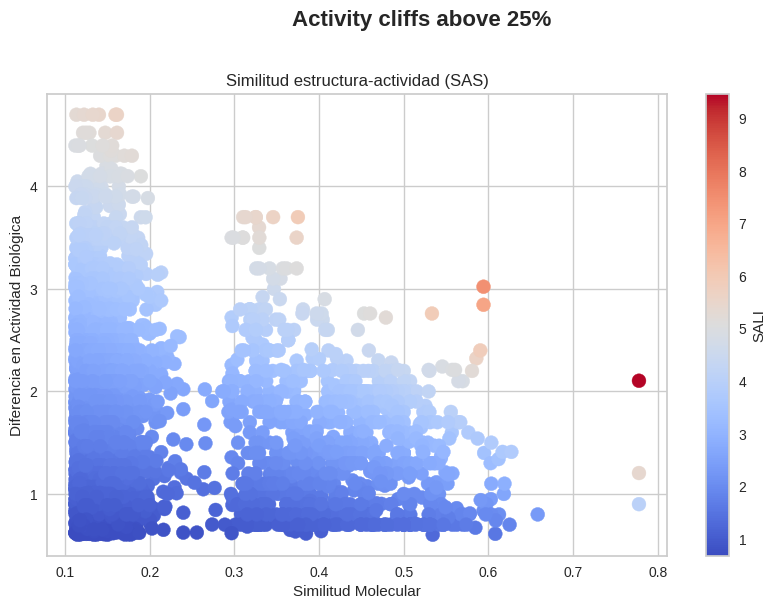

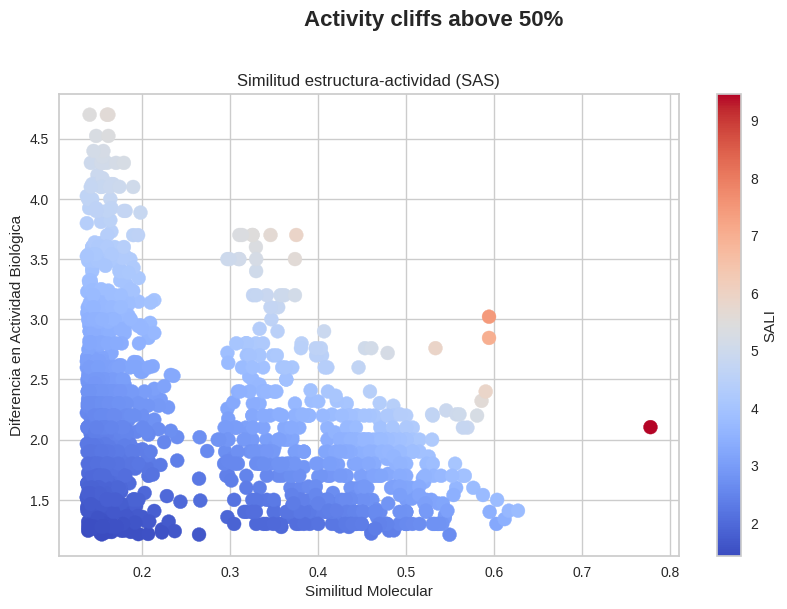

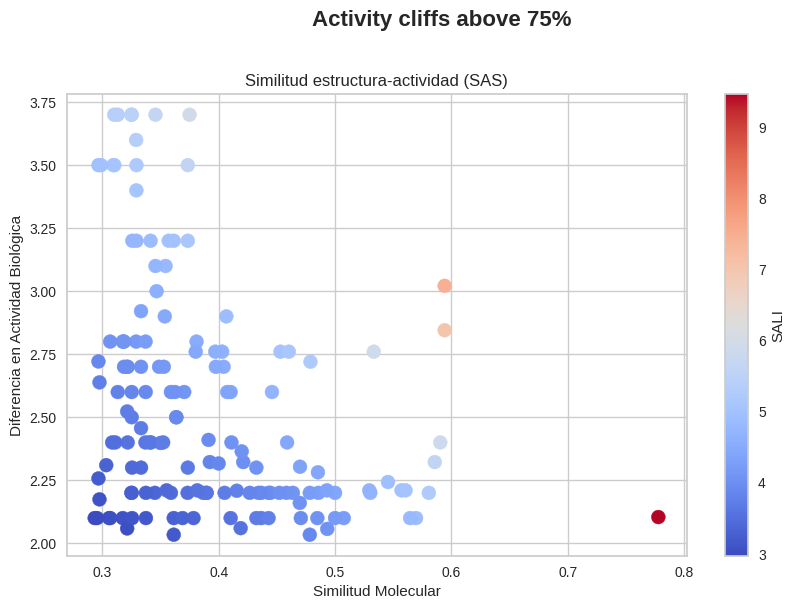

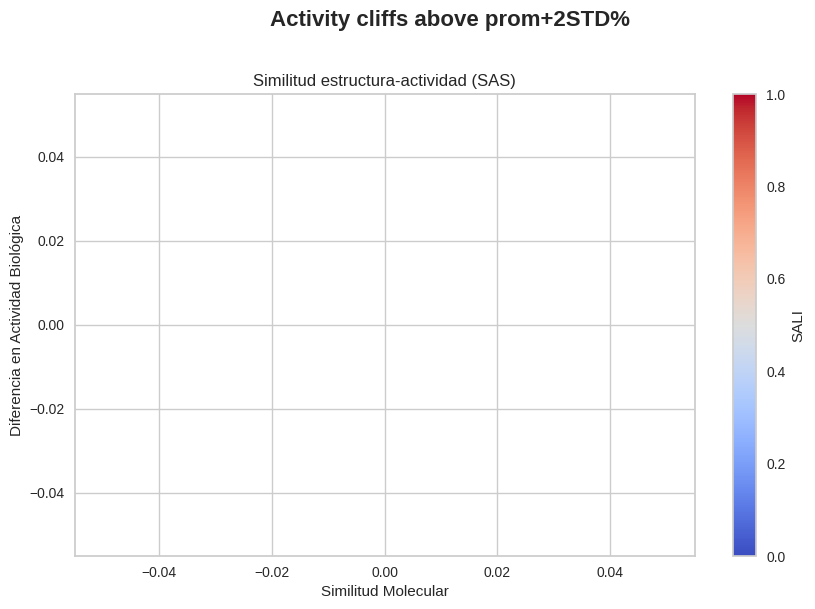

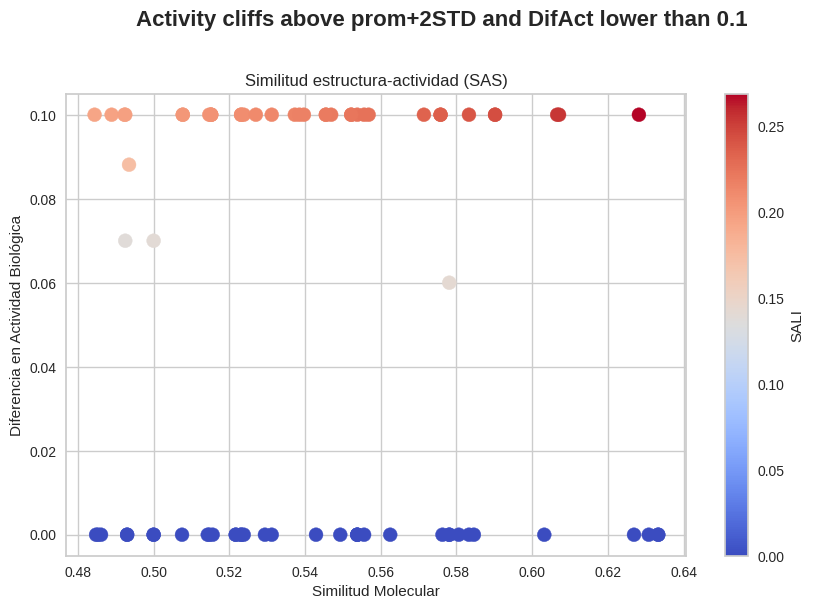

In [27]:
dataframes_dict = {
    'Activity cliffs above 25%': above_25,
    'Activity cliffs above 50%': above_50,
    'Activity cliffs above 75%': above_75,
    'Activity cliffs above prom+2STD%': above_rel_2std,
    'Activity cliffs above prom+2STD and DifAct lower than 0.1': above_rel_2std_01DifAct
}

for name, df in dataframes_dict.items():
    visualización_activity_cliffs(df, title=name)

In [28]:
def visualizacion_activity_cliffs_dinamico(df, title=''):
    # Visualización
    fig_sasmap = px.scatter(df, x="Similitud estructural (Tanimoto)", y="Diferencia de actividad",
                            color="Valor de SALI", color_continuous_scale=['blue', 'red'],
                            hover_data=["Compuesto A", "Compuesto B"])

    # Actualizar el diseño del gráfico
    fig_sasmap.update_layout(
        title_text="Similitud estructura-actividad (SAS)",
        title_x=0.5,
        xaxis_title="Similitud Estructural",
        yaxis_title="Diferencia de actividad",
        hovermode="closest",
        title=dict(text=title, x=0.5, font=dict(size= 20, color='black', family="Arial, sans-serif"))
    )

    fig_sasmap.show()

    return fig_sasmap

In [29]:
 dataframes_dict = {
    'Activity cliffs above 25%': above_25,
    'Activity cliffs above 50%': above_50,
    'Activity cliffs above 75%': above_75,
    'Activity cliffs above prom+2STD%': above_rel_2std,
    'Activity cliffs above prom+2STD and DifAct lower than 0.1': above_rel_2std_01DifAct
}

for name, df in dataframes_dict.items():
    visualizacion_activity_cliffs_dinamico(df, title=name)

<a name='4.2'></a>

## **Identificación de generadores de ACs.**
Pasos
1. Una vez que tenemos un conjunto de datos que cumplen con el siguiente criterio ( dif. act. < 2.0 , Similitud estructrual > 0.5 ), entonces se procede a identificar los compuestos que se repiten dentro de este "subdata frame".
2. A partir de los dos nuevos dataframes que se generaron en el "Paso 1" crear uno nuevo en el cual se puedan identificar los compuestos en común entre ambos dataframes, y sumar su frecuencia de aparición.

Revisar métodos alternos para la obttención del dataframe; en específico, revisar la documentación de Pandas ya que por lo que vi en diferentes ejemplos a través de
Github, pienso que pueden haber "caminos" más cortos y/o óptimos.



In [30]:
 dataframes_dict = {
    'Activity cliffs above 25%': above_25,
    'Activity cliffs above 50%': above_50,
    'Activity cliffs above 75%': above_75,
    'Activity cliffs above prom+2STD%': above_rel_2std,
    'Activity cliffs above prom+2STD and DifAct lower than 0.1': above_rel_2std_01DifAct
}

In [31]:
def calculate_total_frequency(df, column_a, column_b):
    # Paso 1: Crear dataframes individuales para Compuesto A y Compuesto B
    compounds_general_subdata_A = pd.DataFrame().assign(Compuesto=df[column_a])
    compounds_general_subdata_A['Frecuencia'] = compounds_general_subdata_A['Compuesto'].map(compounds_general_subdata_A['Compuesto'].value_counts())
    compounds_general_subdata_A.drop_duplicates(inplace=True)

    compounds_general_subdata_B = pd.DataFrame().assign(Compuesto=df[column_b])
    compounds_general_subdata_B['Frecuencia'] = compounds_general_subdata_B['Compuesto'].map(compounds_general_subdata_B['Compuesto'].value_counts())
    compounds_general_subdata_B.drop_duplicates(inplace=True)

    # Paso 2: Crear un nuevo dataframe que identifique los compuestos comunes y sume sus frecuencias
    subset_combinations_AB = pd.concat([compounds_general_subdata_A, compounds_general_subdata_B], ignore_index=True, sort=False)
    total_frequency_series = subset_combinations_AB.groupby(['Compuesto'])['Frecuencia'].sum()

    # Crear un dataframe a partir de la serie y ordenar por frecuencia
    total_frequency_df = total_frequency_series.to_frame().reset_index()
    total_frequency_df = total_frequency_df.sort_values(["Frecuencia"], ascending=[False])

    return total_frequency_df

In [32]:
# Uso de la función con el dataframe 'cliffs_identification' y las columnas 'Compuesto A' y 'Compuesto B'
frec_above_25 = calculate_total_frequency(above_25, 'Compuesto A', 'Compuesto B')
frec_above_50= calculate_total_frequency(above_50, 'Compuesto A', 'Compuesto B')
frec_above_75 = calculate_total_frequency(above_75, 'Compuesto A', 'Compuesto B')
frec_above_rel_2std = calculate_total_frequency(above_rel_2std, 'Compuesto A', 'Compuesto B')
frec_above_rel_2std_01DifAct = calculate_total_frequency(above_rel_2std_01DifAct, 'Compuesto A', 'Compuesto B')
print(f"Cantidad de activity cliffs identificados por df= 25%: {len(frec_above_25)}, 50%: {len(frec_above_50)}, 75%: {len(frec_above_75)},  Rel: {len(frec_above_rel_2std)}, Rel_2: {len(frec_above_rel_2std_01DifAct)},")
frec_above_25


Cantidad de activity cliffs identificados por df= 25%: 107, 50%: 106, 75%: 64,  Rel: 0, Rel_2: 50,


,Compuesto,Frecuencia
98,CHEMBL485006,94
99,CHEMBL485007,84
23,CHEMBL3739473,82
37,CHEMBL3740375,80
105,CHEMBL519358,79
...,...,...
17,CHEMBL1777876,33
27,CHEMBL3739652,23
21,CHEMBL3311302,21
78,CHEMBL3931570,14


## Visualización de frecuencia de ACs

In [33]:
def fig_frecuency(df, title=''):
  fig_frequency_cliffs = px.bar(df, x='Compuesto', y='Frecuencia', color_discrete_sequence=["OrangeRed"], title=title)
  fig_frequency_cliffs.update_layout(width=700, height=500, bargap=0.05) # hacer cambios en el diseño del gráfico.
  fig_frequency_cliffs.update_layout(title_x = 0.5)
  fig_frequency_cliffs.update_traces(width=0.4)
  fig_frequency_cliffs.show()
  return (fig_frequency_cliffs)

In [34]:
 dataframes_dict = {
    'Activity cliffs above 25%': frec_above_25,
    'Activity cliffs above 50%': frec_above_50,
    'Activity cliffs above 75%': frec_above_75,
    'Activity cliffs above prom+2STD%': frec_above_rel_2std,
    'Activity cliffs above prom+2STD and DifAct lower than 0.1': frec_above_rel_2std_01DifAct
}
for name, df in dataframes_dict.items():
    fig_frecuency(df, title=name)